<a href="https://colab.research.google.com/github/lassana99/EcoVision_PAS_2023/blob/main/Copy_of_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Téléchargement des bibliothèques

In [ ]:
!pip install selenium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.2/400.2 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.2 MB/s eta 0:00:00


In [ ]:
!pip install folium

In [ ]:
!pip install geopandas

#### Téléchargement de chromedriver

In [ ]:
# Set up for running selenium in Google Colab
## You don't need to run this code if you do it in Jupyter notebook, or other local Python setting
%%shell
sudo apt -y update
sudo apt install -y wget curl unzip
wget http://archive.ubuntu.com/ubuntu/pool/main/libu/libu2f-host/libu2f-udev_1.1.4-1_all.deb
dpkg -i libu2f-udev_1.1.4-1_all.deb
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
dpkg -i google-chrome-stable_current_amd64.deb
CHROME_DRIVER_VERSION=`curl -sS chromedriver.storage.googleapis.com/LATEST_RELEASE`
wget -N https://chromedriver.storage.googleapis.com/$CHROME_DRIVER_VERSION/chromedriver_linux64.zip -P /tmp/
unzip -o /tmp/chromedriver_linux64.zip -d /tmp/
chmod +x /tmp/chromedriver
mv /tmp/chromedriver /usr/local/bin/chromedriver

Hit:1 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [553 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,305 kB]
Get:13 http://archive.ub

#### Installation et configuration de chromedriver

In [ ]:
!rm /usr/local/bin/chromedriver
!pip install chromedriver-autoinstaller

import sys
sys.path.insert(0, '/usr/lib/chromium-browser/chromedriver')

import time
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
import chromedriver_autoinstaller

# setup chrome options
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') # ensure GUI is off
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# remove incompatible ChromeDriver
!rm /usr/local/bin/chromedriver

# set path to chromedriver as per your configuration
chromedriver_autoinstaller.install()

# set the target URL
url = "put-url-here-to-scrape"

# set up the webdriver
driver = webdriver.Chrome(options=chrome_options)

rm: cannot remove '/usr/local/bin/chromedriver': No such file or directory


### Importation des bibliothèques

In [ ]:
import folium
import time
import pickle
import matplotlib.pyplot as plt
import os
from selenium import webdriver
import os

from selenium.webdriver.firefox.options import Options
import imageio as iio
import numpy as np
import geopandas as gpd
import numpy

from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

### Creation de la fonction de normalisation des images

In [ ]:
def normalize(img):
    min_val = np.min(img)
    max_val = np.max(img)
    normalized_image = (img - min_val) / (max_val - min_val)
    return normalized_image

### Chargement et lecture du dataset OpenStreetMap

In [ ]:
import geopandas as gpd

In [ ]:
# Set the correct file path to the shapefile
file_path = '/content/drive/MyDrive/senegal-and-gambia-latest-free.shp/gis_osm_landuse_a_free_1.shp'

# Read the shapefile using geopandas
gdf = gpd.read_file(file_path)

# Display the first few rows of the GeoDataFrame


In [ ]:
gdf.head()

,osm_id,code,fclass,name,geometry
0,15933712,7201,forest,None,"POLYGON ((-14.95131 13.71200, -14.95108 13.712..."
1,4103595,7201,forest,None,"POLYGON ((-14.93078 13.65056, -14.93059 13.650..."
2,4103596,7201,forest,None,"POLYGON ((-14.92519 13.64409, -14.92509 13.644..."
3,4114010,7217,scrub,None,"POLYGON ((-16.81421 14.14195, -16.81421 14.142..."
4,4114713,7218,grass,None,"POLYGON ((-16.12162 14.11550, -16.12152 14.115..."


#### 1. Sur la base de nos données, nous disposons d'une géométrie polygonale pour les forêts. Nous devons la convertir en point pour alimenter la bibliothèque folium.

Affichage du crs (système de coordonnées) de notre fichiers

In [ ]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Nous sélectionnons la forêt de Fathala dont l'id est '15521144' et on l'enregistre dans une variable

In [ ]:
id = '15521144'
st = time.time()
# Obtenir l'élément du jeu de données
shapefile_forest = gdf[gdf['osm_id'] == id]
df = shapefile_forest
df.crs
df = df.to_crs(epsg=4326)

# Calculer la localisation en utilisant le point représentatif
location = [float(df.geometry.representative_point().y.iloc[0]), float(df.geometry.representative_point().x.iloc[0])]

2. Nous préparons maintenant l'image principale à l'aide de folium

In [ ]:
m_map = folium.Map(location=[14.4974, -14.4524], width=600, height=600, zoom_start=13, tiles='CartoDB positron')
#Map
#m = folium.Map(location,  zoom_start=20, tiles='CartoDB positron')
tile = folium.TileLayer( tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',         attr = 'Esri',        name = 'Esri Satellite',        overlay = False,        control = False       ).add_to(m_map)

mapFname = 'map.html'
m_map.save(mapFname)
mapUrl = 'file://{0}\\{1}'.format(os.getcwd(), mapFname)
m_map

le code pour trouver le chemin de l'image dans colab

In [ ]:
screenshot_path = os.path.join(os.getcwd(), 'output.png')
print("Chemin de la capture d'écran :", screenshot_path)

Chemin de la capture d'écran : /content/output.png


3. Nous allons maintenant utiliser la même bibliothèque pour ajouter notre objet spatial à la carte et préparer l'image combinée. On la rends spécifiquement super rouge afin de pouvoir la séparer dans un masque plus tard.

In [ ]:
#mask
m = folium.Map(location, width=600, height=600, zoom_start=13, tiles='CartoDB positron')

tile = folium.TileLayer(tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', attr='Esri', name='Esri Satellite', overlay=False, control=False).add_to(m)

style = {"color": "red", "fillOpacity": 0.89}

for _, r in df.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=.5)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: style)
    folium.Popup(r['name']).add_to(geo_j)
    geo_j.add_to(m)

maskFname = 'mask.html'
m.save(maskFname)
maskUrl = 'file://{0}/{1}'.format(os.getcwd(), maskFname)
m

*4. Maintenant, nous prenons l'image et le masque et nous les exportons en utilisant le pilote Selenium Firefox.*

In [ ]:
#### export map and mask
##### You can find both of these images in the folder of

# download gecko driver for  from here - https://github.com/mozilla/geckodriver/releases

options = Options()
options.headless = True
##options = Options()
options.binary_location = r'/usr/lib/chromium-browser/chromedriver'#### you may need to update this path
driver = webdriver.Chrome(options=chrome_options)



###Map_export_portion
# use selenium to save the html as png image
driver.get(mapUrl)
# wait for 5 seconds for the maps and other assets to be loaded in the browser
time.sleep(5)
driver.save_screenshot('map.png')

####mask_export_portion
driver.get(maskUrl)
# wait for 5 seconds for the maps and other assets to be loaded in the browser
time.sleep(5)
driver.save_screenshot('mask.png')
driver.quit()

*5. Nous pouvons maintenant lire l'image du masque et le code Focus sur la couche rouge et la transformer en un masque binaire.Les dernières lignes de ce code lisent l'image satellite brute du site.*

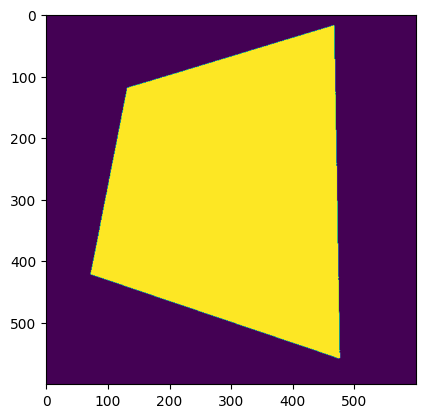

In [ ]:
import imageio.v2 as iio

img = iio.imread('mask.png')
##portion = china[120:250, 110:230]
img =img [0:600, 0:600]

r = img[:,:,0]
b = img[:,:,1]
g = img[:,:,2]
img_red=r>150
   ## plt.imshow(img_red)
img_blue=      b>100
img_green=      g>100
   ## plt.imshow(img_blue)
img_other = (img_red.astype(np.float32) * img_blue.astype(np.float32)).astype(bool)
img_mask = (img_red.astype(np.float32) - img_other.astype(np.float32)).astype(bool)

plt.imshow(img_mask)
#import map
img_map= iio.imread('map.png')
##portion = china[120:250, 110:230]
img_map =img_map [0:600, 0:600]
img_map=normalize(img_map)
plt.imshow(img_mask)

Enfin, nous combinons ces cinq étapes et créer une boucle pour parcourir chaque enregistrement et ajouter l'image et le masque dans deux tableaux que nous pourrons ensuite introduire dans le réseau neuronal.Par ailleurs, nous avons subdivisé le cadre de données pour obtenir 300 images de la classe forêt uniquement.

In [ ]:
###create a subset
gdf_subset=gdf[gdf['fclass'] =="forest"].reset_index()
gdf_subset=gdf[:100]
len(gdf_subset)

100

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
[21]
[22]
[23]
[24]
[25]
[26]
[27]
[28]
[29]
[30]
[31]
[32]
[33]
[34]
[35]
[36]
[37]
[38]
[39]
[40]
[41]
[42]
[43]
[44]
[45]
[46]
[47]
[48]
[49]
[50]
[51]
[52]
[53]
[54]
[55]
[56]
[57]
[58]
[59]
[60]
[61]
[62]
[63]
[64]
[65]
[66]
[67]
[68]
[69]
[70]
[71]
[72]
[73]
[74]
[75]
[76]
[77]
[78]
[79]
[80]
[81]
[82]
[83]
[84]
[85]
[86]
[87]
[88]
[89]
[90]
[91]
[92]
[93]
[94]
[95]
[96]
[97]
[98]
[99]
loop time: 1110.8730762004852 seconds


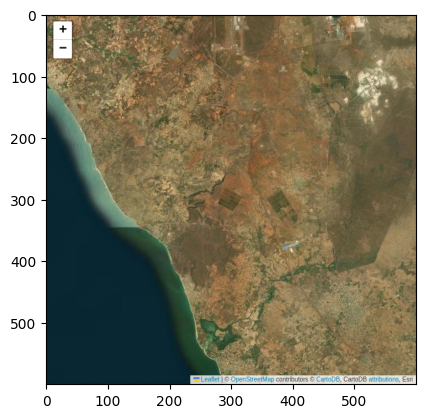

In [ ]:
img_map_array = []
img_mask_array = []
st = time.time()

options = Options()
options.headless = True
driver = webdriver.Chrome(options=chrome_options)

for i in range(len(gdf_subset)):
    print([i])
    id = gdf_subset['osm_id'][i]
    shapefile_forest = gdf[gdf['osm_id'] == id]
    df = shapefile_forest
    df.crs
    df = df.to_crs(epsg=4326)

    location = [float(df.geometry.representative_point().y.iloc[0]), float(df.geometry.representative_point().x.iloc[0])]
    m_map = folium.Map(location, width=600, height=600, zoom_start=12, tiles='CartoDB positron')
    tile = folium.TileLayer(tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', attr='Esri',
                           name='Esri Satellite', overlay=False, control=False).add_to(m_map)

    mapFname = 'map.html'
    m_map.save(mapFname)
    mapUrl = 'file://{0}\\{1}'.format(os.getcwd(), mapFname)

    m = folium.Map(location, width=600, height=600, zoom_start=12, tiles='CartoDB positron')
    tile = folium.TileLayer(tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', attr='Esri',
                           name='Esri Satellite', overlay=False, control=False).add_to(m)

    style = {"color": "red", "fillOpacity": 0.89}

    for _, r in df.iterrows():
        sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.5)
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: style)
        folium.Popup(r['name']).add_to(geo_j)
        geo_j.add_to(m)

    maskFname = 'mask.html'
    m.save(maskFname)
    maskUrl = 'file://{0}\\{1}'.format(os.getcwd(), maskFname)

    driver.get(mapUrl)
    time.sleep(5)
    driver.save_screenshot('map.png')

    driver.get(maskUrl)
    time.sleep(5)
    driver.save_screenshot('mask.png')

    img = iio.imread('mask.png')
    img = img[0:600, 0:600]
    r = img[:, :, 0]
    b = img[:, :, 1]
    g = img[:, :, 2]
    img_red = r > 150
    img_blue = b > 100
    img_green = g > 100
    img_other = (img_red.astype(np.float32) * img_blue.astype(np.float32)).astype(bool)
    img_mask = (img_red.astype(np.float32) - img_other.astype(np.float32)).astype(bool)
    plt.imshow(img_mask)

    img_map = iio.imread('map.png')
    img_map = img_map[0:600, 0:600]
    img_map = normalize(img_map)
    plt.imshow(img_map)

    mask_final = []
    img_mask0 = img_mask * -1 + 1
    img_mask1 = img_mask.astype(int)
    mask_final.append(img_mask0)
    mask_final.append(img_mask1)
    mask_final = np.array(mask_final)
    mask_final = mask_final.transpose([1, 2, 0])

    img_map_array.append(img_map)
    img_mask_array.append(mask_final)

     # Libérer la mémoire en supprimant les variables inutiles
    del m_map
    del m
    del mask_final
    del img
    del r
    del b
    del g
    del img_red
    del img_blue
    del img_green
    del img_other
    del img_mask
    del img_map

et = time.time()
elapsed_time = et - st
print('loop time:', elapsed_time, 'seconds')
driver.quit()
img_map_array = np.array(img_map_array)
img_mask_array = np.array(img_mask_array)

# Prototype du modèle

In [ ]:
###from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import TensorBoard

In [ ]:
from tensorflow.keras import regularizers

def simple_unet_model(n_classes=2, im_sz=600, n_channels=4, n_filters_start=4, growth_factor=2):
    # Création d'un modèle de réseau à l'aide de l'API fonctionnelle:
    n_filters = n_filters_start
    inputs = Input((im_sz, im_sz, n_channels))

    # Ajoute les régularisations L1, L2, et L1_L2 dans les couches de convolution
    reg_l1 = regularizers.l1(0.01)  # Paramètre de régularisation L1 (à ajuster selon tes besoins)
    reg_l2 = regularizers.l2(0.01)  # Paramètre de régularisation L2 (à ajuster selon tes besoins)
    reg_l1_l2 = regularizers.l1_l2(l1=0.01, l2=0.01)  # Paramètres de régularisation L1_L2 (à ajuster selon tes besoins)

    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same', kernel_regularizer=reg_l1)(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    n_filters *= growth_factor  # increase number of filters when going down the U-Net
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same', kernel_regularizer=reg_l2)(pool1)
    n_filters //= growth_factor  # decrease number of filters when going up the U-Net
    upconv = Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv2)
    concat = concatenate([conv1, upconv])
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same', kernel_regularizer=reg_l1_l2)(concat)
    output = Conv2D(n_classes, (1, 1), activation='sigmoid')(conv3)

    model = Model(inputs=inputs, outputs=output)
    # Compilation du modèle avec l'optimiseur ADAM et logloss (aka binary crossentropy) comme fonction de perte
    model.compile(optimizer=Adam(), loss='binary_crossentropy')
    return model

model = simple_unet_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 600, 600, 4)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 600, 600, 4)          148       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 300, 300, 4)          0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 300, 300, 8)          296       ['max_pooling2d[0][0]']   

In [ ]:
x_train=img_map_array[0:80]
x_test=img_map_array[80:]
y_train=img_mask_array[0:80]
y_test=img_mask_array[80:]
x_train.shape
# Entraînement du modèle:
st = time.time()
N_EPOCHS =50
BATCH_SIZE = 32
# demander à Keras de sauvegarder les meilleurs poids (en termes de perte de validation) dans un fichier:
model_checkpoint = ModelCheckpoint(filepath='weights_simple_unet.hdf5', monitor='val_loss', save_best_only=True)
# demander à Keras d'enregistrer chaque perte d'époch:
csv_logger = CSVLogger('log.csv', append=True, separator=';')
# demander à Keras d'enregistrer les informations au format TensorBoard:
tensorboard = TensorBoard(log_dir='tensorboard_simple_unet/', write_graph=True, write_images=True)
# Entrainement:
model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS,
          verbose=2, shuffle=True,
          callbacks=[model_checkpoint, csv_logger, tensorboard],
          validation_data=(x_test, y_test))

et = time.time()
elapsed_time = et - st
print('loop time:', elapsed_time, 'seconds')

Epoch 1/50
3/3 - 70s - loss: 1.3466 - val_loss: 1.3210 - 70s/epoch - 23s/step
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 - 42s - loss: 1.3207 - val_loss: 1.2937 - 42s/epoch - 14s/step
Epoch 3/50
3/3 - 41s - loss: 1.2940 - val_loss: 1.2661 - 41s/epoch - 14s/step
Epoch 4/50
3/3 - 41s - loss: 1.2671 - val_loss: 1.2373 - 41s/epoch - 14s/step
Epoch 5/50
3/3 - 41s - loss: 1.2393 - val_loss: 1.2079 - 41s/epoch - 14s/step
Epoch 6/50
3/3 - 39s - loss: 1.2108 - val_loss: 1.1776 - 39s/epoch - 13s/step
Epoch 7/50
3/3 - 41s - loss: 1.1816 - val_loss: 1.1467 - 41s/epoch - 14s/step
Epoch 8/50
3/3 - 42s - loss: 1.1517 - val_loss: 1.1148 - 42s/epoch - 14s/step
Epoch 9/50
3/3 - 41s - loss: 1.1208 - val_loss: 1.0823 - 41s/epoch - 14s/step
Epoch 10/50
3/3 - 39s - loss: 1.0891 - val_loss: 1.0492 - 39s/epoch - 13s/step
Epoch 11/50
3/3 - 48s - loss: 1.0570 - val_loss: 1.0159 - 48s/epoch - 16s/step
Epoch 12/50
3/3 - 41s - loss: 1.0243 - val_loss: 0.9822 - 41s/epoch - 14s/step
Epoch 13/50
3/3 - 41s - loss: 0.9913 - val_loss: 0.9483 - 41s/epoch - 14s/step
Epoch 14/50
3/3 - 41s - loss: 0.9578 - val_loss: 0.9142 - 41s/epoch - 1

In [ ]:
# Évaluation du modèle sur les données de test
test_loss = model.evaluate(x_test, y_test, verbose=0)
print("Test Loss:", test_loss)

Test Loss: 0.29051634669303894
